# Polynômes de chaos : application au cas de la poutre encastrée avec chaos par intégration

## Résumé

Dans ce notebook, nous présentons la décomposition en chaos polynomial du cas de la poutre encastrée. Nous montrons comment calculer les coefficients par intégration.

In [1]:
import openturns as ot

In [2]:
dist_E = ot.Beta(0.9, 2.2, 2.8e7, 4.8e7)
dist_E.setDescription(["E"])
F_para = ot.LogNormalMuSigma(3.0e4, 9.0e3, 15.0e3)  # in N
dist_F = ot.ParametrizedDistribution(F_para)
dist_F.setDescription(["F"])
dist_L = ot.Uniform(250.0, 260.0)  # in cm
dist_L.setDescription(["L"])
dist_I = ot.Beta(2.5, 1.5, 310.0, 450.0)  # in cm^4
dist_I.setDescription(["I"])

myDistribution = ot.ComposedDistribution([dist_E, dist_F, dist_L, dist_I])

In [3]:
dim_input = 4  # dimension of the input
dim_output = 1  # dimension of the output


def function_beam(X):
    E, F, L, I = X
    Y = F * (L ** 3) / (3 * E * I)
    return [Y]


g = ot.PythonFunction(dim_input, dim_output, function_beam)
g.setInputDescription(myDistribution.getDescription())

## Create a polynomial chaos decomposition

On crée la base polynomiale multivariée par tensorisation de polynômes univariés avec la règle d'énumération linéaire par défaut.

In [4]:
multivariateBasis = ot.OrthogonalProductPolynomialFactory(
    [dist_E, dist_F, dist_L, dist_I]
)

Generate an training sample of size N with MC simulation (or retrieve the design from experimental data).

In [5]:
N = 50  # size of the experimental design

inputTrain = myDistribution.getSample(N)
outputTrain = g(inputTrain)

Nous devons une règle de troncature : ici, nous avons choisit la `FixedStrategy`, ce qui revient à conserver les `P` premiers polynômes de la base de polynômes. Dans notre cas particulier, nous avons déterminé `P` en utilisant la méthode  `getStrataCumulatedCardinal`, de telle sorte que c'est l'ensemble des polynômes multivariés de degré total inférieur ou égal à 5 qui est conservé. 

In [6]:
totalDegree = 5
enumfunc = multivariateBasis.getEnumerateFunction()
P = enumfunc.getStrataCumulatedCardinal(totalDegree)
adaptiveStrategy = ot.FixedStrategy(multivariateBasis, P)
adaptiveStrategy

class=FixedStrategy derived from class=AdaptiveStrategyImplementation maximumDimension=126

On observe que le nombre de polynômes correspondant à notre règle de troncature est égal à 126.

Définit la règle de calcul des coefficients ; nous choisissons la méthode par intégration.

On commence par obtenir la mesure standard associée à la base polynomiale multivariée. On observe que l'intervalle de définition de la loi `Beta` est standardisée entre -1 et 1. Il en est de même pour la loi `Uniform` et la seconde loi `Beta`.

In [7]:
distributionMu = multivariateBasis.getMeasure()
distributionMu

class=ComposedDistribution name=ComposedDistribution dimension=4 copula=class=IndependentCopula name=IndependentCopula dimension=4 marginal[0]=class=Beta name=Beta dimension=1 alpha=0.9 beta=2.2 a=-1 b=1 marginal[1]=class=LogNormal name=LogNormal dimension=1 muLog=9.46206 sigmaLog=0.554513 gamma=0 marginal[2]=class=Uniform name=Uniform dimension=1 a=-1 b=1 marginal[3]=class=Beta name=Beta dimension=1 alpha=2.5 beta=1.5 a=-1 b=1

In [8]:
marginalDegrees = [4] * dim_input
experiment = ot.GaussProductExperiment(distributionMu, marginalDegrees)

On peut observer la taille du plan d'expériences associé.

In [9]:
experiment.generate().getSize()

256

On observe que la règle de quadrature est associée à un plan d'expériences de taille 256.

In [10]:
projectionStrategy = ot.IntegrationStrategy(experiment)

On peut maintenant créer le chaos fonctionnel. 

In [11]:
chaosalgo = ot.FunctionalChaosAlgorithm(
    g, myDistribution, adaptiveStrategy, projectionStrategy
)
chaosalgo.run()

Get the result


In [12]:
result = chaosalgo.getResult()

La méthode `getMetaModel` retourne une fonction permettant d'évaluer le métamodèle.

In [13]:
metamodel = result.getMetaModel()

## Validate the metamodel

Generate a validation sample (which is independent of the training sample).

In [14]:
n_valid = 1000
inputTest = myDistribution.getSample(n_valid)
outputTest = g(inputTest)

La classe `MetaModelValidation` permet de valider le métamodèle sur une base de validation.

In [15]:
val = ot.MetaModelValidation(inputTest, outputTest, metamodel)

Compute the $Q^2$ predictivity coefficient

In [16]:
Q2 = val.computePredictivityFactor()[0]
Q2

0.999954548578549

Plot the observed versus the predicted outputs.

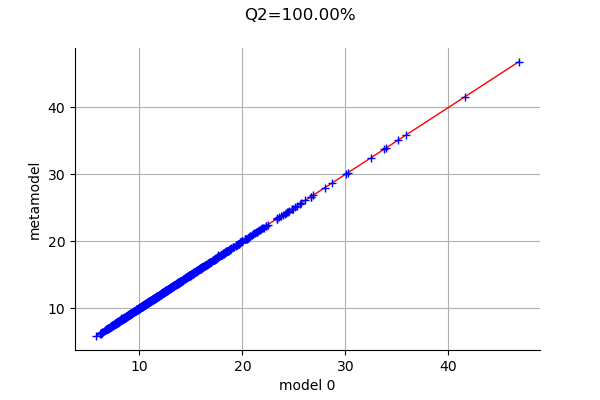

In [17]:
graph = val.drawValidation()
graph.setTitle("Q2=%.2f%%" % (Q2 * 100))
graph

## Sensitivity analysis

Retrieve Sobol' sensitivity measures associated to the polynomial chaos decomposition of the model.

In [18]:
chaosSI = ot.FunctionalChaosSobolIndices(result)
print(chaosSI.summary())

 input dimension: 4
 output dimension: 1
 basis size: 126
 mean: [12.6246]
 std-dev: [4.28184]
------------------------------------------------------------
Index   | Multi-indice                  | Part of variance  
------------------------------------------------------------
      2 | [0,1,0,0]                     | 0.782385
      1 | [1,0,0,0]                     | 0.131389
      4 | [0,0,0,1]                     | 0.0544568
      6 | [1,1,0,0]                     | 0.011825
      3 | [0,0,1,0]                     | 0.0100206
------------------------------------------------------------


------------------------------------------------------------
Component | Sobol index            | Sobol total index      
------------------------------------------------------------
        0 | 0.133693               | 0.14681               
        1 | 0.782385               | 0.80035               
        2 | 0.0100216              | 0.0111615             
        3 | 0.0548741              | 0.

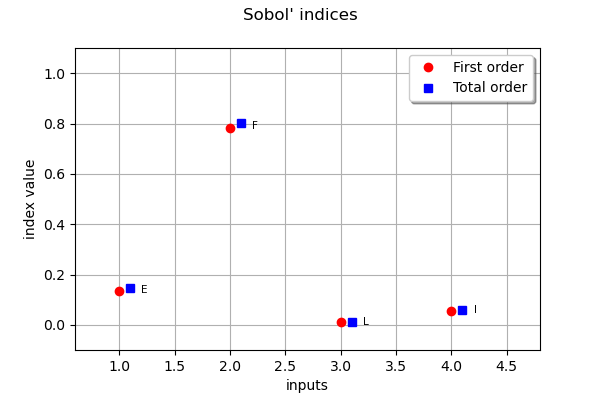

In [19]:
first_order = [chaosSI.getSobolIndex(i) for i in range(dim_input)]
total_order = [chaosSI.getSobolTotalIndex(i) for i in range(dim_input)]
input_names = g.getInputDescription()
ot.SobolIndicesAlgorithm.DrawSobolIndices(input_names, first_order, total_order)

## Conclusion

* On observe que les coefficients sont relativement bien estimés puisque le Q2 est excellent (parfait ?), malgré un nombre de points relativement réduit dans le plan d'expériences (256 points).